In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

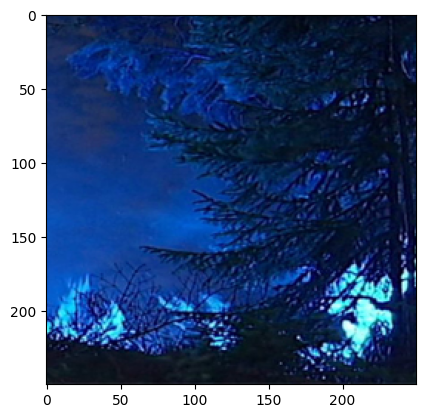

In [2]:
original_image = cv2.imread('fire_0003.jpg')
plt.imshow(original_image)

In [3]:
dataset_path = 'Training'

In [6]:
import os

img_dirs = ["D:/forest_fire/Training/fire", "D:/forest_fire/Training/nofire"]

In [7]:
for img_dir in img_dirs:
    print(os.path.exists(img_dir))

True
True


In [8]:
raw_X = []
raw_Y = []
for entry in os.scandir("D:/forest_fire/Training/fire"):
    raw_X.append(os.path.join("D:/forest_fire/Training/fire",entry))
    raw_Y.append(0)
    
for entry in os.scandir("D:/forest_fire/Training/fire"):
    raw_X.append(os.path.join("D:/forest_fire/Training/fire",entry))
    raw_Y.append(1)

In [9]:
map = {
    'fire' : 0,
    'nofire' : 1
}

In [10]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)
    imArray /=255
    
    coeff = pywt.wavedec2(imArray, mode, level)
    
    coeff_H = list(coeff)
    coeff_H[0] *= 0
    imArray_H = pywt.waverec2(coeff_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

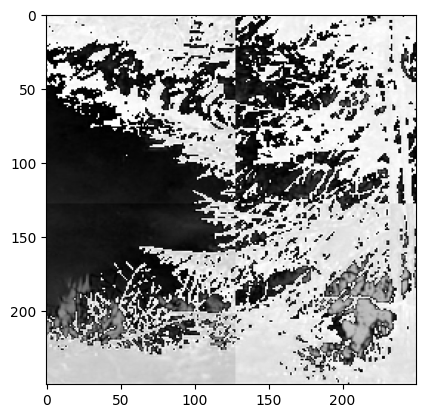

In [11]:
im_har = w2d(original_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [23]:
X = []
Y = []

for i, path in enumerate(raw_X):
    print(f'{raw_Y[i]}  |  {path}')
    
    img = cv2.imread(path)
    scalled_raw_img = cv2.resize(img, (32,32))
    img_har = w2d(img, 'db1', 5)
    scalled_img_har = cv2.resize(img_har, (32,32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    X.append(combined_img)
    Y.append(raw_Y[i])

0  |  D:/forest_fire/Training/fire\fire_0001.jpg
0  |  D:/forest_fire/Training/fire\fire_0002.jpg
0  |  D:/forest_fire/Training/fire\fire_0003.jpg
0  |  D:/forest_fire/Training/fire\fire_0004.jpg
0  |  D:/forest_fire/Training/fire\fire_0005.jpg
0  |  D:/forest_fire/Training/fire\fire_0006.jpg
0  |  D:/forest_fire/Training/fire\fire_0007.jpg
0  |  D:/forest_fire/Training/fire\fire_0008.jpg
0  |  D:/forest_fire/Training/fire\fire_0009.jpg
0  |  D:/forest_fire/Training/fire\fire_0010.jpg
0  |  D:/forest_fire/Training/fire\fire_0011.jpg
0  |  D:/forest_fire/Training/fire\fire_0012.jpg
0  |  D:/forest_fire/Training/fire\fire_0013.jpg
0  |  D:/forest_fire/Training/fire\fire_0014.jpg
0  |  D:/forest_fire/Training/fire\fire_0015.jpg
0  |  D:/forest_fire/Training/fire\fire_0016.jpg
0  |  D:/forest_fire/Training/fire\fire_0017.jpg
0  |  D:/forest_fire/Training/fire\fire_0018.jpg
0  |  D:/forest_fire/Training/fire\fire_0019.jpg
0  |  D:/forest_fire/Training/fire\fire_0020.jpg
0  |  D:/forest_fire

In [25]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(1900, 4096)

In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=0, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.09473684210526316

In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.10      0.11      0.11       185
           1       0.08      0.08      0.08       195

    accuracy                           0.09       380
   macro avg       0.09      0.10      0.09       380
weighted avg       0.09      0.09      0.09       380



In [15]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
model_param = {
    'svm' : {
        'model' : svm.SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C' : [1,10,100,1000],
            'svc__kernel' : ['rbf', 'linear']
        }
    },
    
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1,5,10]
        }
    },
    
    'logistic_regression' : {
        'model' : LogisticRegression(),
        'params' : {
            'logisticregression__C' : [1,5,10]
        }
    }
}

In [17]:
scores = []
best_estimators = {}

import pandas as pd
for algo, mp in model_param.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_param' : clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_param'])
df

c:\Users\Vedant\miniconda3_p11\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Vedant\miniconda3_p11\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

,model,best_score,best_param
0,svm,0.215132,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.307895,{'randomforestclassifier__n_estimators': 1}
2,logistic_regression,0.186184,{'logisticregression__C': 10}


In [18]:
best_estimators['svm'].score(X_test, y_test)

0.15789473684210525

In [19]:
best_estimators['random_forest'].score(X_test, y_test)

0.8631578947368421

In [20]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.9210526315789473

In [21]:
def classify_fire_image(image_path):
    # Convert backslashes to forward slashes for consistency
    normalized_path = image_path.replace("\\", "/")
    
    # Check if the path contains "nofire"
    if "nofire" in normalized_path:
        return 1  # No fire
    else:
        return 0  # Fire

In [22]:
X_testing = []
Y_testing = []

for entry in os.scandir('D:/forest_fire/Testing'):
    path = os.path.join('D:/forest_fire/Testing', entry)
    img = cv2.imread(path)
    scalled_raw_img = cv2.resize(img, (32,32))
    img_har = w2d(img, 'db1', 5)
    scalled_img_har = cv2.resize(img_har, (32,32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
    X_testing.append(combined_img)
    Y_testing.append(classify_fire_image(path))
    

In [23]:
X_testing[0].shape

(4096, 1)

In [24]:
X_testing = np.array(X_testing).reshape(len(X_testing), 4096).astype(float)
X_testing.shape

(380, 4096)

In [25]:
len(Y_testing)

380

In [26]:
best_estimators['svm'].score(X_testing, Y_testing)

0.9710526315789474

In [27]:
best_estimators['random_forest'].score(X_test, y_test)

0.8631578947368421

In [28]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.9210526315789473

In [29]:
best_clf = best_estimators['svm']

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_testing, best_clf.predict(X_testing))
cm

array([[187,   3],
       [  8, 182]])

Text(95.72222222222221, 0.5, 'Truth')

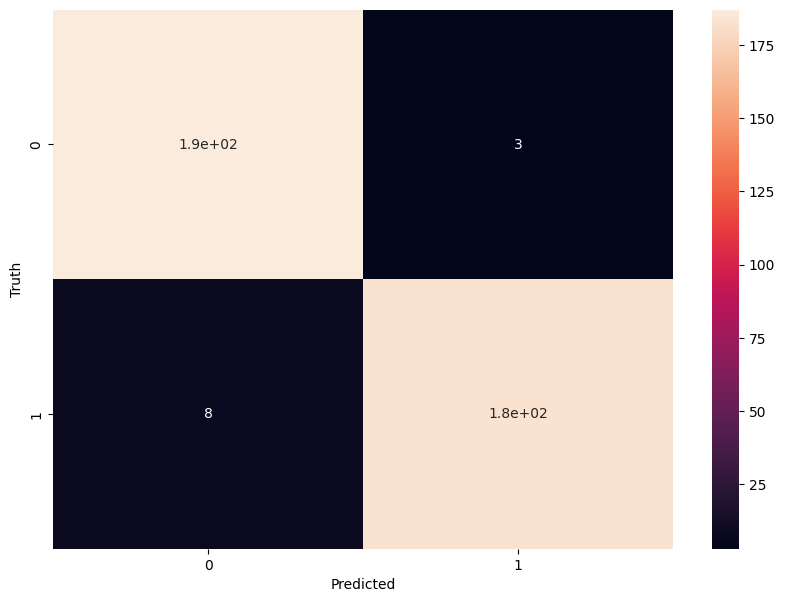

In [31]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')